---
### Invert with regularization.
Please check the origional paper:\
[Felipe A. Bulat, Tim Heaton-Burgess, Aron J. Cohen, and Weitao Yang, J. Chem. Phys. 127, 174101 (2007)](https://aip.scitation.org/doi/full/10.1063/1.2800021?casa_token=-ZgE4QLD_g0AAAAA%3AEKtFcuAPeo8_BGf_3CHsaCfPBletRKQgCgwE87XnpcJzZ1x_TPdeqDTltYzC9Uj9rqcukhbtOgAlhA)\
[Tim Heaton-Burgess, Felipe A. Bulat, and Weitao Yang, PRL 98, 256401 (2007)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.256401)

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

In [2]:
Ne = psi4.geometry( 
""" 
0 1
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole momentes instead.
wfn = psi4.properties("ccsd/aug-cc-pvtz",  return_wfn=True, molecule=Ne, property=['dipole'])[1]

# Build inverter and set target
ine = n2v.Inverter(wfn, pbs="aug-cc-pvqz")

#### Result without regularization

In [3]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.invert("WuYang", opt_method="trust-exact", guide_potential_components=["fermi_amaldi"])

Optimization Successful within 6 iterations! |grad|=4.64e-07


In [4]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grids = np.array([x,y,z])

vH, vFA = ine.on_grid_esp(grid=grids)[1:3]

vrest = ine.on_grid_ao(ine.v_opt, grid=grids, basis=ine.pbs)

vxc = vFA + vrest - vH

Accoding to the two paper I cited above,
$$
P(\lambda) = \lambda \frac{\|v_{rest}(\lambda)\|^2}{L^{\lambda=0}-L^{\lambda}},
$$
where $L$ is the Lagrangian.\
$T_s$ is the non-interacting kinetic energy.

In [17]:
opt = {"maxiter": 100,
       "disp": False,
       "gtol": 1e-3}
lambda_list, P, Ts = ine.find_regularization_constant(guide_potential_components=["fermi_amaldi"], 
                                                      opt_method="trust-exact",
                                                      lambda_list=10 ** np.linspace(-1,-7,21), opt=opt)
print("lambda:\n", lambda_list)
print("P:\n", P)

lambda:
 [1.00000000e-01 5.01187234e-02 2.51188643e-02 1.25892541e-02
 6.30957344e-03 3.16227766e-03 1.58489319e-03 7.94328235e-04
 3.98107171e-04 1.99526231e-04 1.00000000e-04 5.01187234e-05
 2.51188643e-05 1.25892541e-05 6.30957344e-06 3.16227766e-06
 1.58489319e-06 7.94328235e-07 3.98107171e-07 1.99526231e-07
 1.00000000e-07]
P:
 [ 0.07775369  0.11537444  0.14546447  0.16146452  0.18336162  0.24847785
  0.47859211  0.85484578  1.68367764  3.04857796  5.50611629  9.04228191
 20.56887488 49.24075346         inf         inf         inf         inf
         inf         inf         inf]


/home/yuming/PDFT/n2v/n2v/methods/wuyang.py:291: RuntimeWarning: divide by zero encountered in true_divide
  P_list = lambda_list * np.array(v_norm_list) / (L0 - np.array(L_list))


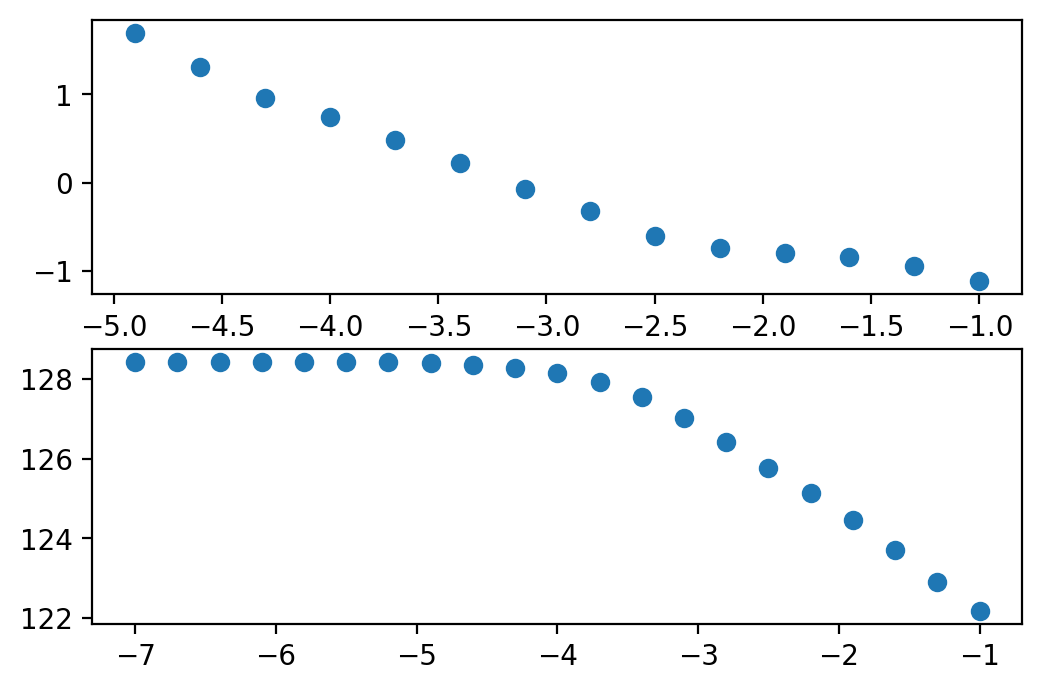

In [19]:
fig, axes = plt.subplots(2,1,dpi=200)
axes[0].scatter(np.log10(lambda_list), np.log10(P), label="P")
axes[1].scatter(np.log10(lambda_list), Ts, label="Ts")

Following the $\lambda$ suggested by P (in the printed list, the first element before $P=\infty$)

In [20]:
lambda_list[13]

1.2589254117941661e-05

In [21]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.invert("WuYang", guide_potential_components=["fermi_amaldi"], reg=lambda_list[13])

Optimization Successful within 5 iterations! |grad|=2.34e-06


In [22]:
vrest_P = ine.on_grid_ao(ine.v_opt, grid=grids, basis=ine.pbs)

vxc_P = vFA + vrest_P - vH

Following the $\lambda$ suggested by Ts (the edge of the L curve in the bottom panel)

In [23]:
lambda_list[12]

2.5118864315095822e-05

In [24]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.invert("WuYang", guide_potential_components=["fermi_amaldi"], reg=lambda_list[12])

Optimization Successful within 4 iterations! |grad|=5.71e-06


In [25]:
vrest_Ts = ine.on_grid_ao(ine.v_opt, grid=grids, basis=ine.pbs)
vxc_Ts = vFA + vrest_Ts - vH

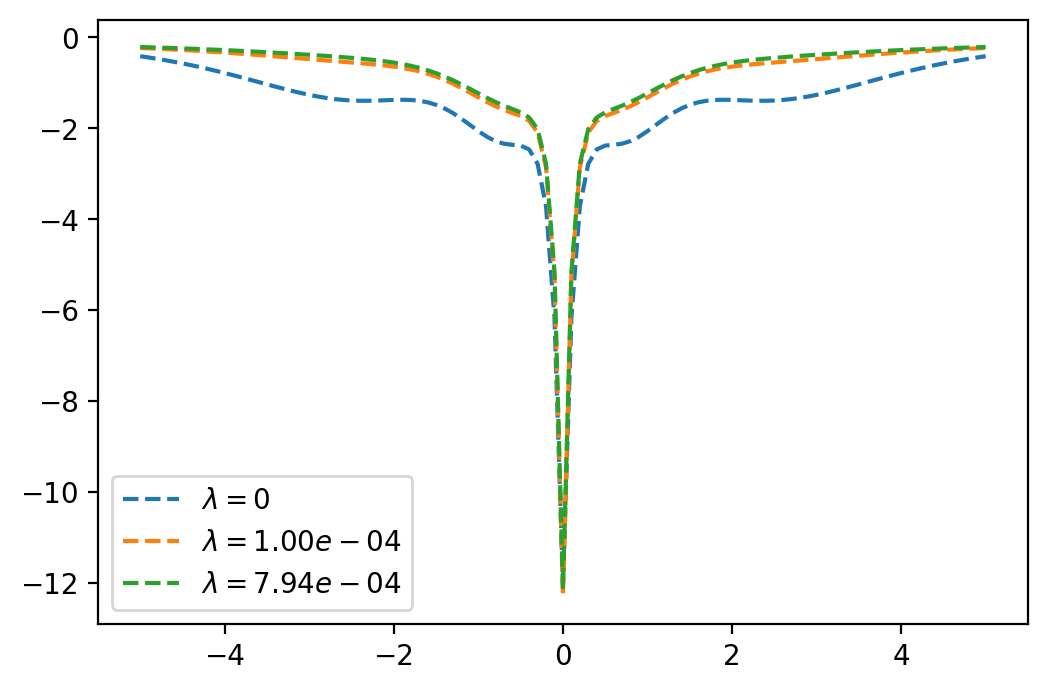

In [26]:
fig, ax = plt.subplots(dpi=200)
# ax.plot(xyz, vxc_exact, label="exact")
ax.plot(x, vxc, label="$\lambda=0$", ls='--')
ax.plot(x, vxc_P, label="$\lambda=%.2e$"%lambda_list[10], ls='--')
ax.plot(x, vxc_Ts, label="$\lambda=%.2e$"%lambda_list[7], ls='--')
ax.legend()